In [1]:
from matplotlib import pyplot as plt 

In [2]:
import json

In [3]:
import re

In [4]:
import numpy as np

In [5]:
def bucket(x, size):
    l = len(x)
    buckets = []
    i = 0
    while i < l:
        buckets.append(sum(x[i:i+size])/len(x[i:i+size]))
        i+=size
    return buckets

In [6]:
def moving_average(x, w):
    return np.convolve(x, np.ones(w), 'valid') / w

In [7]:
class LogReader():
    def __init__(self, filename, keys):
        self.file = open(f'{filename}')
        self.keys = set(keys)
        self.matches = {}
        for key in keys:
            self.matches[key]=[]
    
    def grab(self):
        line = next(self.file, None)
        while line:
            split = line.strip().split('=')
            if len(split)==2:
                query = split[0]
                value = float(split[1])
                if query in self.keys:
                    self.matches[query].append(value)
            line = next(self.file, None)
        return self.matches

In [8]:
tasks = [
    ('atac_region', 'gene'),
    ('gene', 'atac_region'),
    ('gene', 'protein_name'),
    ('protein_name', 'gene'),
]

In [9]:
base_keys = [
    'train zero one loss',
    'train value loss',
    'train prediction loss',
    'validation zero one loss',
    'validation value loss',
    'validation prediction loss',
]

keys = []
for key in base_keys:
    for task in tasks:
        keys.append(f'{key} {task}')

In [10]:
keys += [
    'Batch',
    'Epoch',
]

#### Bucket Size

In [11]:
bucket_size = 10

In [12]:
readers = {}
matches = {}

#### Timestamp of run

In [13]:
timestamps = [
    '20211115-1420',
]
files = [f'logs/train_earl_{tmstp}.log' for tmstp in timestamps]

In [14]:
for file in files:
    if file not in readers:
        readers[file] = LogReader(file, keys)
        matches = readers[file].grab()

## Select File

In [15]:
idx = 0

## Get matching log lines

In [16]:
file = files[idx]
matches = readers[file].grab()

## Parameters of this run

In [17]:
import json
from pprint import pprint

In [18]:
pprint(json.load(open(f'logs/earl_params_{timestamps[idx]}.json')))

{'atac_ones_weight': 1,
 'checkpoint': 25,
 'device': 'cuda:3',
 'gene_ones_weight': 1,
 'layers': [['SAGEConv', {'out_channels': 128}],
            ['SAGEConv', {'out_channels': 128}],
            ['SAGEConv', {'out_channels': 128}],
            ['SAGEConv', {'out_channels': 128}],
            ['SAGEConv', {'out_channels': 128}],
            ['SAGEConv', {'out_channels': 128}],
            ['SAGEConv', {'out_channels': 128}],
            ['SAGEConv', {'out_channels': 128}]],
 'lr': 0.001,
 'n_steps': 15000,
 'out_mlp': {'bias': True,
             'dim_in': 128,
             'dim_inner': 512,
             'dim_out': 1,
             'num_layers': 4},
 'train_batch_size': 5,
 'validation_batch_size': 100}


## Current Batch

In [19]:
batch = matches['Batch'][-1]
batch

2550.0

## Training loss

('atac_region', 'gene') 0.3878
('gene', 'atac_region') 0.2113
('gene', 'protein_name') 0.1776
('protein_name', 'gene') 0.2987


<Figure size 1080x720 with 0 Axes>

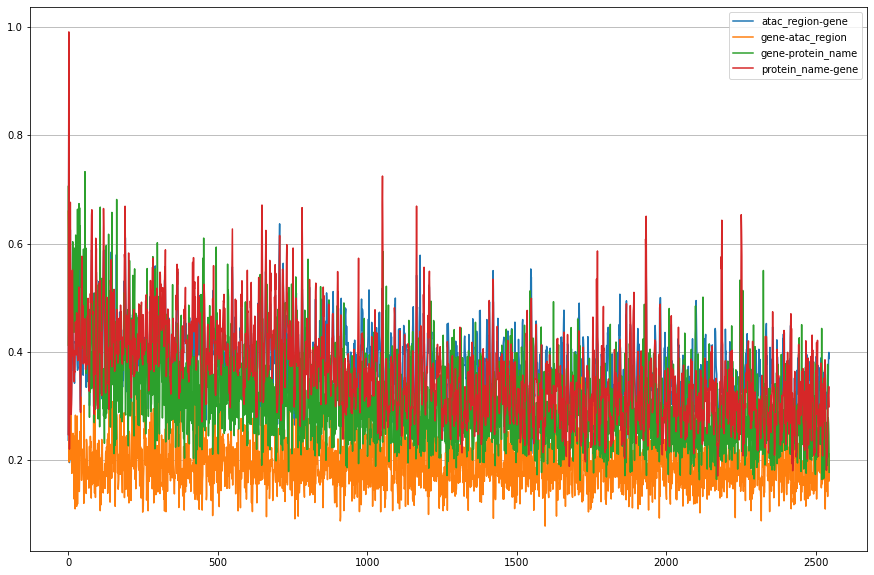

In [20]:
plt.figure(figsize=(15,10))
fig,ax = plt.subplots(figsize=(15,10))
plt.grid(axis='y')

for task in tasks:
    training_loss = matches[f'train prediction loss {task}']
    ax.plot(training_loss[5:], label=f'{task[0]}-{task[1]}')
    print(task, f'{training_loss[-1]:.4f}')
_=ax.legend()


('atac_region', 'gene') 0.3877544224262237
('gene', 'atac_region') 0.2112596333026886
('gene', 'protein_name') 0.1775859624147415
('protein_name', 'gene') 0.2986995339393616


<Figure size 1080x720 with 0 Axes>

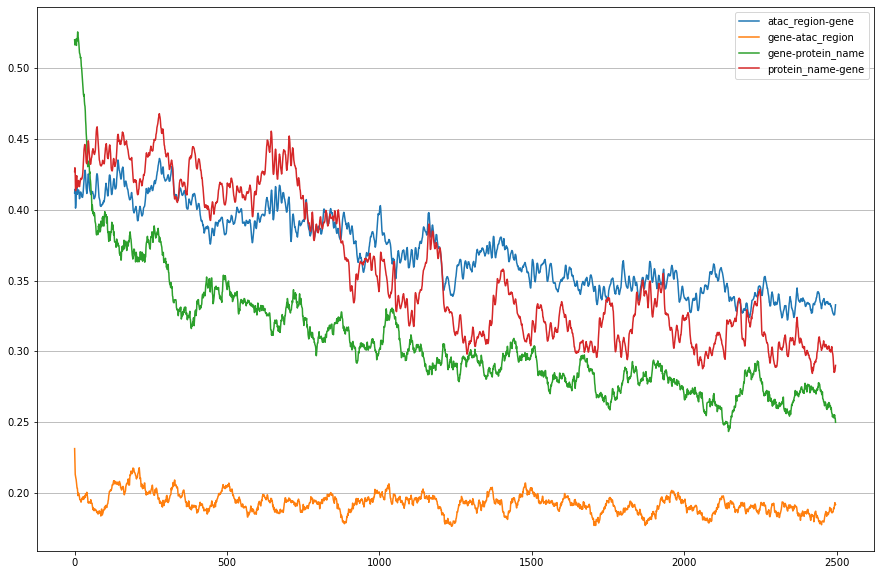

In [21]:
plt.figure(figsize=(15,10))
fig,ax = plt.subplots(figsize=(15,10))
plt.grid(axis='y')

for task in tasks:
    training_loss = matches[f'train prediction loss {task}']
    ax.plot(moving_average(training_loss[5:],50), label=f'{task[0]}-{task[1]}')
    print(task, training_loss[-1])
_=ax.legend()


## Validation Loss

('atac_region', 'gene') 0.345938134044409
('gene', 'atac_region') 0.1822470724582672
('gene', 'protein_name') 0.2643019059300422
('protein_name', 'gene') 0.30171995386481276


<Figure size 1080x720 with 0 Axes>

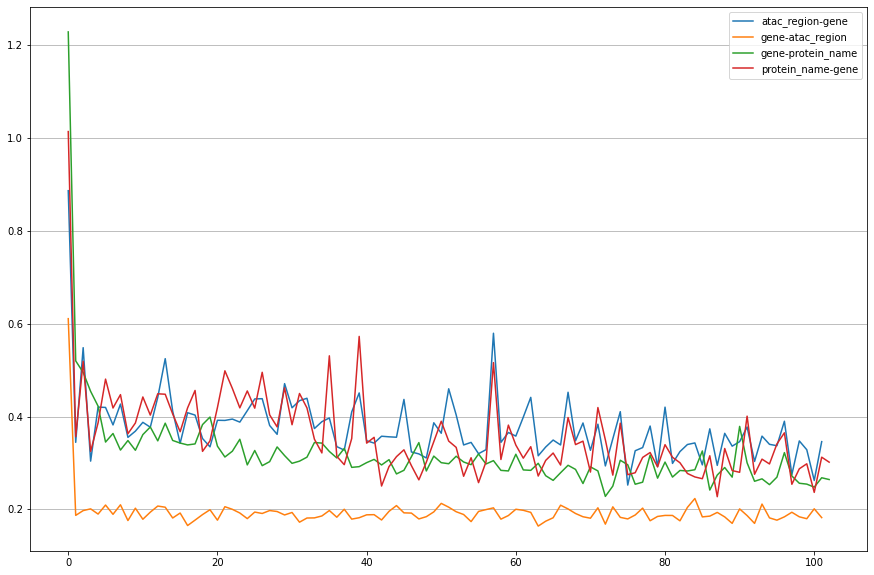

In [22]:
plt.figure(figsize=(15,10))
fig,ax = plt.subplots(figsize=(15,10))
plt.grid(axis='y')

for task in tasks:
    validation_loss = matches[f'validation prediction loss {task}']
    _=ax.plot(validation_loss, label=f'{task[0]}-{task[1]}')
    print(task, validation_loss[-1])
_=ax.legend()

## Sample predictions

In [23]:
prediction_file = open(f'logs/train_earl_prediction_sample_{timestamps[idx]}.log')

In [24]:
import time

In [25]:
for line in prediction_file:
    print(line.strip())
    time.sleep(.1)    

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Task: ('protein_name', 'gene')
--------------------------------------------------------------------------------
batch 2550 0      pred,y:   1.006 0.000
batch 2550 1      pred,y:   1.265 0.000
batch 2550 2      pred,y:   0.000 0.000
batch 2550 3      pred,y:   0.000 0.000
batch 2550 4      pred,y:   0.000 0.000
batch 2550 5      pred,y:   0.000 0.000
batch 2550 6      pred,y:   0.000 0.000
batch 2550 7      pred,y:   0.000 0.000
batch 2550 8      pred,y:   1.054 0.000
batch 2550 9      pred,y:   0.000 0.000
batch 2550 10     pred,y:   0.000 0.908
batch 2550 11     pred,y:   0.000 0.000
batch 2550 12     pred,y:   0.000 0.000
batch 2550 13     pred,y:   0.000 0.000
batch 2550 14     pred,y:   0.000 0.000
batch 2550 15     pred,y:   0.000 0.000
batch 2550 16     pred,y:   1.142 0.000
batch 2550 17     pred,y:   0.000 0.908
batch 2550 18     pred,y:   0.000 0.000
batch 2550 19     pred,y:   1.008 0.000
batch 2550 20     pred,y:   0.000 0.000
batch 2550 21     pred,y:   0.000 0.000
batch 25

batch 2550 203    pred,y:   0.000 0.000
batch 2550 204    pred,y:   0.000 0.908
batch 2550 205    pred,y:   0.000 0.000
batch 2550 206    pred,y:   0.000 0.000
batch 2550 207    pred,y:   0.000 0.000
batch 2550 208    pred,y:   0.000 0.000
batch 2550 209    pred,y:   0.000 0.000
batch 2550 210    pred,y:   0.000 0.000
batch 2550 211    pred,y:   0.000 0.000
batch 2550 212    pred,y:   0.000 0.000
batch 2550 213    pred,y:   0.000 0.000
batch 2550 214    pred,y:   0.000 0.000
batch 2550 215    pred,y:   0.000 0.000
batch 2550 216    pred,y:   0.000 0.000
batch 2550 217    pred,y:   0.000 0.000
batch 2550 218    pred,y:   0.000 0.000
batch 2550 219    pred,y:   1.251 0.000
batch 2550 220    pred,y:   0.000 0.000
batch 2550 221    pred,y:   0.000 0.000
batch 2550 222    pred,y:   1.032 0.000
batch 2550 223    pred,y:   0.000 0.000
batch 2550 224    pred,y:   0.000 0.908
batch 2550 225    pred,y:   0.000 0.000
batch 2550 226    pred,y:   0.000 0.000
batch 2550 227    pred,y:   0.000 0.000


batch 2550 104    pred,y:   0.000 0.000
batch 2550 105    pred,y:   0.536 0.624
batch 2550 106    pred,y:   1.423 0.832
batch 2550 107    pred,y:   1.502 0.832
batch 2550 108    pred,y:   0.934 1.280
batch 2550 109    pred,y:   0.512 0.624
batch 2550 110    pred,y:   0.000 0.000
batch 2550 111    pred,y:   1.294 1.005
batch 2550 112    pred,y:   0.280 0.000
batch 2550 113    pred,y:   0.000 0.360
batch 2550 114    pred,y:   0.554 0.360
batch 2550 115    pred,y:   0.786 0.000
batch 2550 116    pred,y:   0.741 1.005
batch 2550 117    pred,y:   0.000 1.280
batch 2550 118    pred,y:   0.686 0.000
batch 2550 119    pred,y:   1.475 1.496
batch 2550 120    pred,y:   0.000 1.751
batch 2550 121    pred,y:   0.540 0.000
batch 2550 122    pred,y:   0.565 0.000
batch 2550 123    pred,y:   0.000 0.000
batch 2550 124    pred,y:   0.749 0.000
batch 2550 125    pred,y:   0.000 0.000
batch 2550 126    pred,y:   0.000 0.360
batch 2550 127    pred,y:   0.681 0.360
batch 2550 128    pred,y:   0.594 0.000


batch 2550 171    pred,y:   0.000 0.000
batch 2550 172    pred,y:   0.000 0.000
batch 2550 173    pred,y:   1.330 0.000
batch 2550 174    pred,y:   1.392 1.504
batch 2550 175    pred,y:   0.000 0.000
batch 2550 176    pred,y:   0.000 0.000
batch 2550 177    pred,y:   0.000 0.000
batch 2550 178    pred,y:   0.000 0.000
batch 2550 179    pred,y:   0.000 1.204
batch 2550 180    pred,y:   0.000 0.773
batch 2550 181    pred,y:   0.000 0.000
batch 2550 182    pred,y:   0.000 0.000
batch 2550 183    pred,y:   0.000 0.000
batch 2550 184    pred,y:   1.397 0.000
batch 2550 185    pred,y:   0.000 0.000
batch 2550 186    pred,y:   0.000 0.000
batch 2550 187    pred,y:   0.000 0.000
batch 2550 188    pred,y:   0.000 0.000
batch 2550 189    pred,y:   0.000 0.000
batch 2550 190    pred,y:   0.000 0.000
batch 2550 191    pred,y:   0.000 0.000
batch 2550 192    pred,y:   1.532 0.000
batch 2550 193    pred,y:   0.000 0.000
batch 2550 194    pred,y:   0.000 0.773
batch 2550 195    pred,y:   0.000 0.000
